In [80]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve , auc

from PIL import Image
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
# Specify transforms using torchvision.transforms as transforms
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [82]:
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
train_set = datasets.ImageFolder("CT_Skull_Fractures/data/train", transform = transformations)
val_set = datasets.ImageFolder("CT_Skull_Fractures/data/test", transform = transformations)

In [83]:
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [84]:
# Get pretrained model using torchvision.models as models library
model = models.densenet161(pretrained=True)

# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

In [85]:
# Create new classifier for model using torch.nn as nn library

# Initialize classifier
classifier_input = model.classifier.in_features

# number of classes
num_labels = 2 

classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))

# Replace default classifier with new classifier
model.classifier = classifier

In [86]:
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device specified above
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [87]:
# Set the error function using torch.nn as nn library
criterion = nn.NLLLoss()

# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

In [88]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [89]:
# save model for future fast inference

PATH = 'CT_Skull_Fractures/interactive/model_outputs/mymodel.pth'
torch.load(PATH)

# Load probs. 
lossiloss = np.load("CT_Skull_Fractures/interactive/model_outputs/lossiloss.npy")
valiloss = np.load("CT_Skull_Fractures/interactive/model_outputs/valiloss.npy")
acc = np.load("CT_Skull_Fractures/interactive/model_outputs/acc.npy")
epoc = np.load("CT_Skull_Fractures/interactive/model_outputs/epoc.npy")


print("model and probs. uploaded successfuly!")

model and probs. uploaded successfuly!


In [90]:
# Load model - starting inference

net = model
net.load_state_dict(torch.load(PATH))
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()
outputs = net(images)
classes = ('b', 'nb')

_, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(len(classes))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


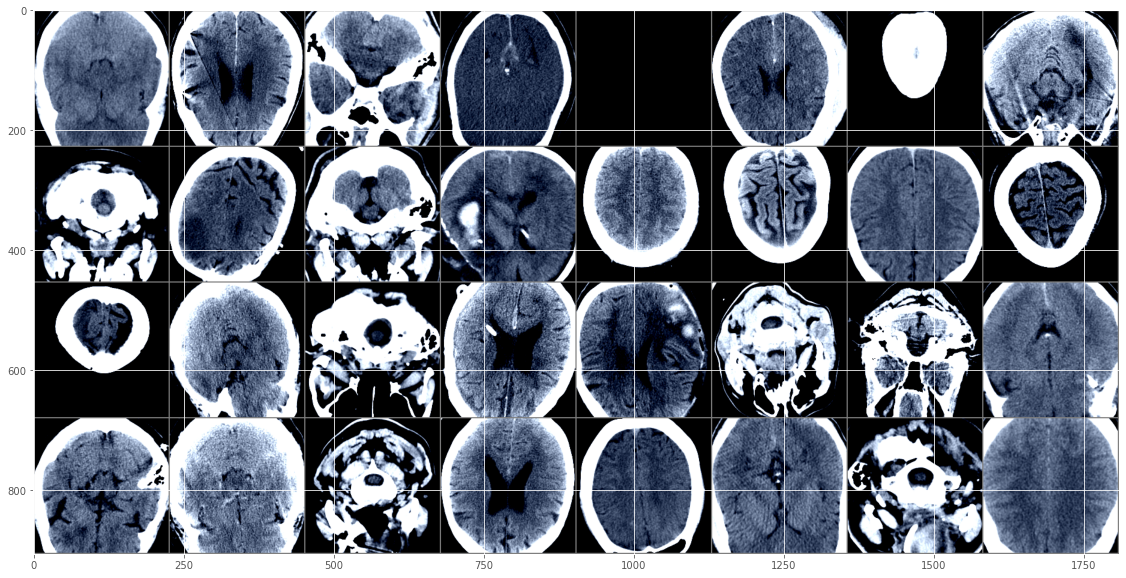

In [91]:
plt.figure(figsize=(20,10))


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig("CT_Skull_Fractures/interactive/plots/pretrained_imgs.png")
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [92]:
# Print total validation accuracy of the model

correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 86 %


In [93]:
# Classes accuracy

class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(classes)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print it
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     b : 33 %
Accuracy of    nb : 90 %


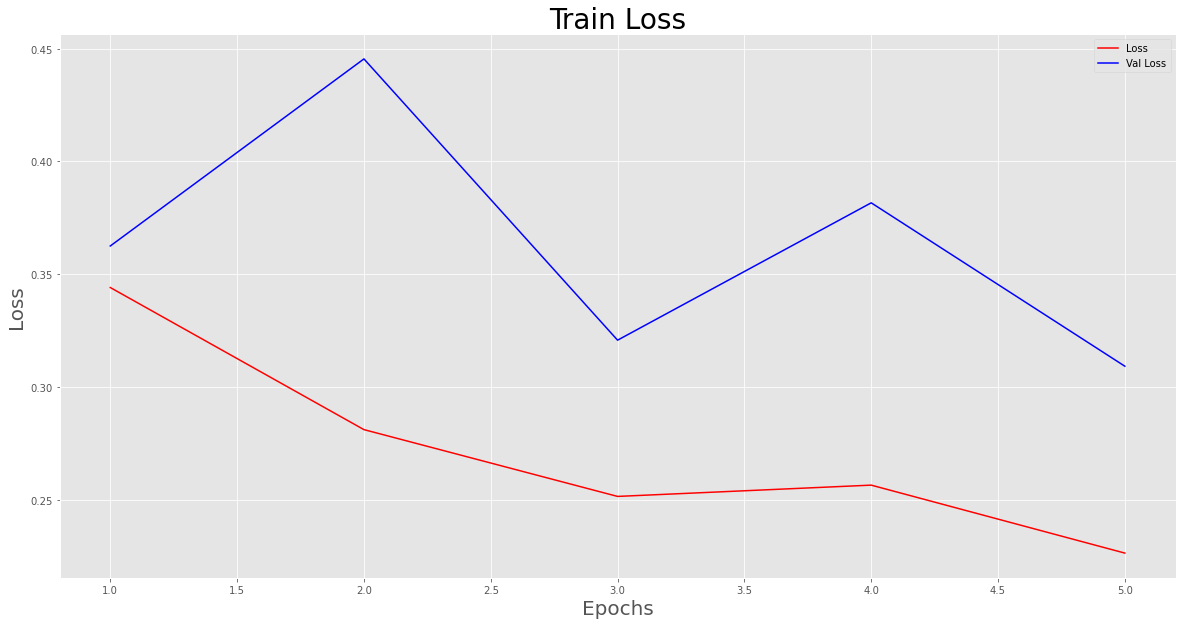

In [94]:

# Loss plot
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(epoc,lossiloss, color="red")
plt.plot(epoc,valiloss, color="blue")
plt.legend(['Loss', 'Val Loss'], loc='upper right')
plt.title("Train Loss", size=28)
plt.xlabel("Epochs", size=20)
plt.ylabel("Loss", size=20)
#plt.savefig("/homedtic/ikoren/skull/plots/loss.png")
plt.show()

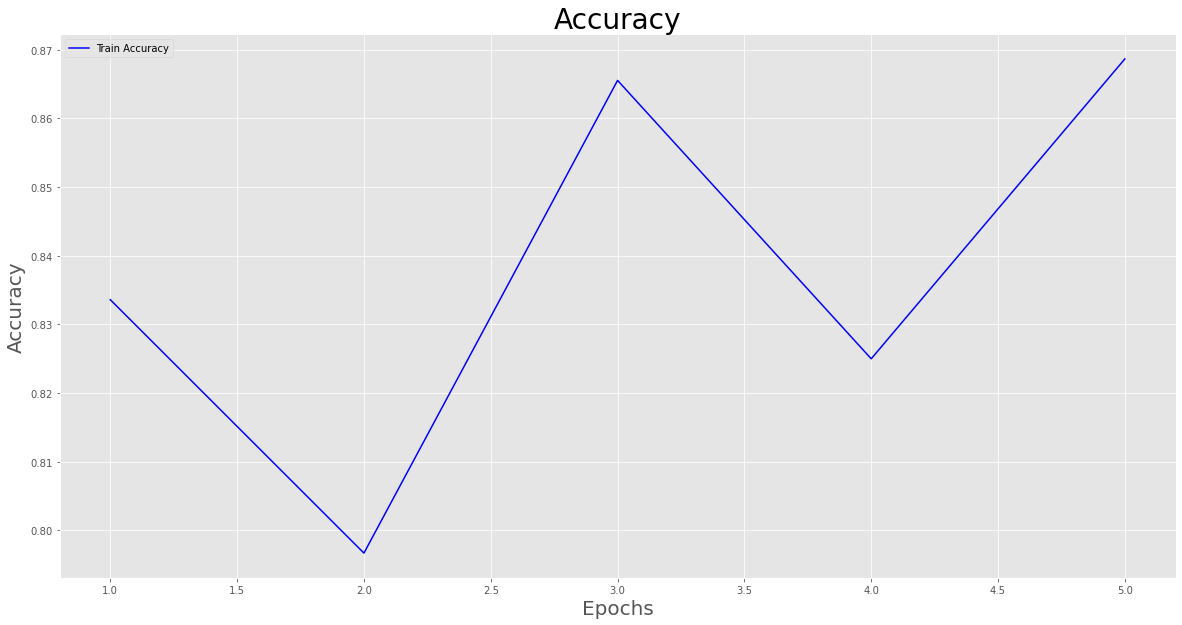

In [95]:
# Accuracy plot
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(epoc,acc, color="blue")
plt.legend(['Train Accuracy'], loc='upper left')
plt.title("Accuracy", size=28)
plt.xlabel("Epochs", size=20)
plt.ylabel("Accuracy", size=20)
plt.savefig("CT_Skull_Fractures/interactive/plots/accuracy.png")
plt.show()

In [96]:
# Confusion Matrix

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, val_loader)
print('Confusion matrix:\n==================')
print(confusion_matrix(actuals, predictions))
print()
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print("=========")
print()
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print("===============")

Confusion matrix:
[[ 214  169]
 [ 116 1672]]

F1 score: 0.868724

Accuracy score: 0.868724


In [97]:
# Class Definition

dataset = datasets.ImageFolder('CT_Skull_Fractures/data/train', transform=transformations)
classes1 = dataset.class_to_idx
classes1

{'b': 0, 'nb': 1}

In [100]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    model.cpu()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.cpu()
            target = target.cpu()
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

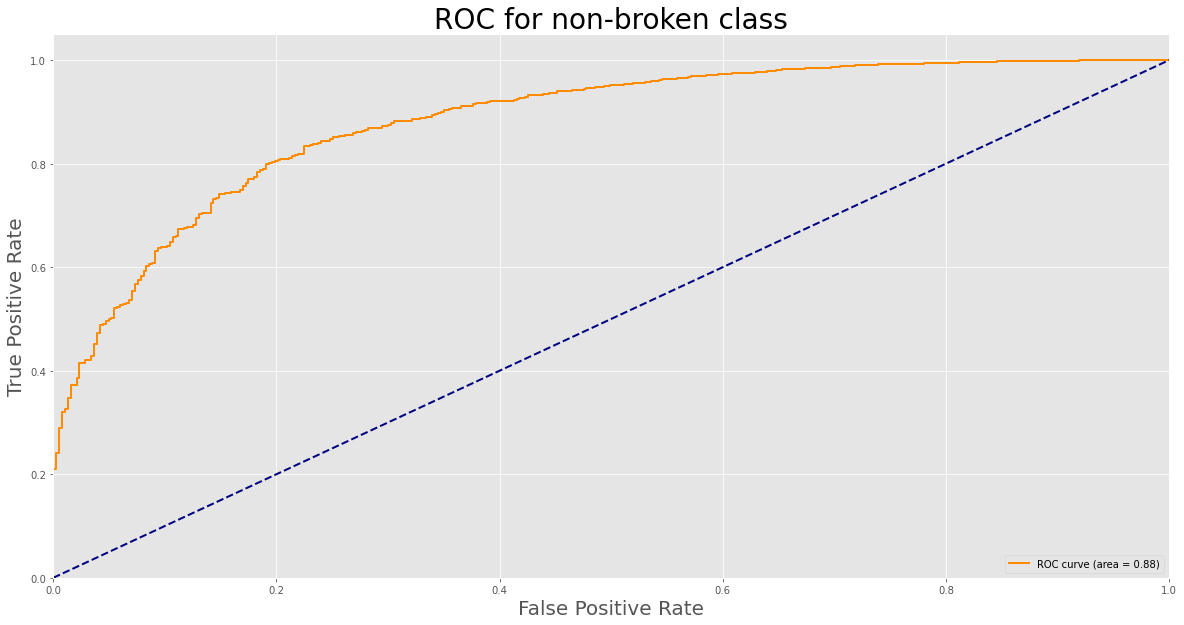

In [101]:
which_class = 1 # non-broken 

actuals, class_probabilities = test_class_probabilities(model, device, val_loader, which_class)

# save probs. for future fast inference
np.save("class_probabilities.npy", class_probabilities)
np.save("actuals.npy", actuals)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)

# plt config
plt.style.use('ggplot')
plt.figure(figsize=(20,10))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('ROC for non-broken class', size=28)
plt.legend(loc="lower right")
plt.savefig("CT_Skull_Fractures/interactive/plots/roc_nb.png")
plt.show()

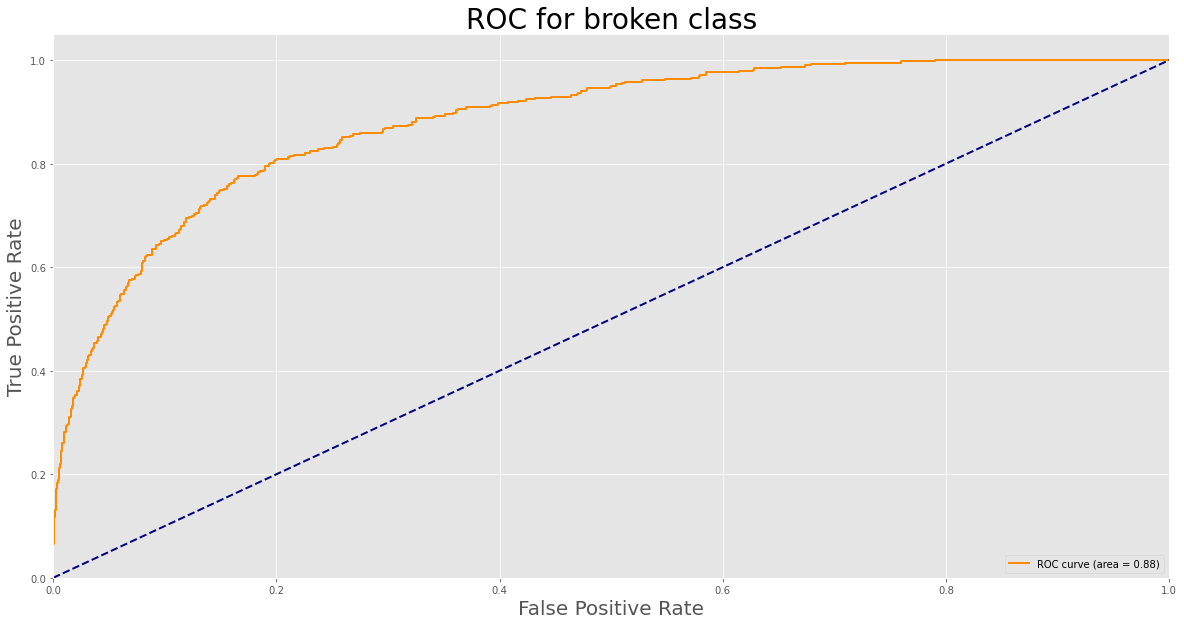

In [102]:
which_class = 0 # broken 
actuals, class_probabilities = test_class_probabilities(model, device, val_loader, which_class)

# save probs. for future fast inference
np.save("class_probabilities_b.npy", class_probabilities)
np.save("actuals_b.npy", actuals)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)

# plt config
plt.style.use('ggplot')
plt.figure(figsize=(20,10))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate' , size = 20)
plt.ylabel('True Positive Rate' , size = 20)
plt.title('ROC for broken class' , size = 28)
plt.legend(loc="lower right")
plt.savefig("CT_Skull_Fractures/interactive/plots/ROC_Broken.png")
plt.show()

In [108]:
def predict_image(image):
    image_tensor = transformations(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    input = input.cpu()
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index


def get_random_images(num):
    data = datasets.ImageFolder('CT_Skull_Fractures/data/test/', transform=transformations)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

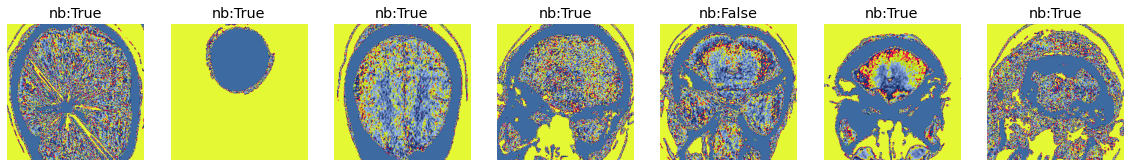

In [110]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))

to_pil = transforms.ToPILImage()
images, labels = get_random_images(7)

for i in range(len(images)):
    image = to_pil(images[i])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), i+1)
    res = int(labels[i]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

# Show images
plt.show()